# Introduction

The main European soccer dataset is from https://www.kaggle.com/hugomathien/soccer/home, and the supplementary dataset that includes the goal type is from https://www.kaggle.com/jiezi2004/soccer/home.

The dataset covers the seasons from 2008 to 2016 (from the 2008/09 season to the 2015/16 season). <br>
The goals are just for the domestic league matches.

**Question 1**: Who scores most of their goals through penalty kicks?<br>
**Question 2**: When are the goals scored?

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## *Question 1: Who scores most of their goals through penalty kicks?*

### Import data

In [2]:
with sqlite3.connect('./database.sqlite') as conn:
    countries = pd.read_sql_query("SELECT * from Country", conn)
    matches = pd.read_sql_query("SELECT * from Match", conn)
    leagues = pd.read_sql_query("SELECT * from League", conn)
    teams = pd.read_sql_query("SELECT * from Team", conn)
    players = pd.read_sql_query("SELECT * from Player", conn)

goals = pd.read_csv('goal_detail.csv', low_memory=False)

### Join the tables
I want some column from each of the tables, so I will use inner joins.

In [3]:
goals = pd.merge(goals, players, how='inner', left_on='player1', right_on='player_api_id')
goals = pd.merge(goals, matches, how='inner', left_on='match_id', right_on='id')
goals = pd.merge(goals, teams, how='inner', left_on='team', right_on='team_api_id')
goals = pd.merge(goals, leagues, how='inner', left_on='league_id', right_on='id')
goals.rename({'name': 'league'}, axis='columns', inplace=True)

### Drop unwanted columns

In [4]:
all_columns = goals.columns.tolist()
columns_to_keep = ['player_name', 'team_long_name', 'season', 'league', 'date', 'goal_type']
columns_to_drop = [c for c in all_columns if c not in columns_to_keep]
goal_data = goals.drop(columns_to_drop, axis=1, inplace=False)
goal_data = goal_data.sort_values(by=['player_name', 'season', 'date'])
goal_data['date'] = goal_data['date'].str.slice(0,10)

### Create columns for goal types

In [5]:
goal_categories = pd.get_dummies(goal_data['goal_type'])
goal_data = pd.concat([goal_data, goal_categories], axis=1)

### A sanity check with Luis Suarez
(He scores a lot of goals and has changed teams in both summer and winter.)

According to Wikipedia,
- Luis Suarez scored **64** goals for **Ajax** from 2008 to 2010.
- He moved to **Liverpool** in the 2010 January transfer window and scored **69** goals from 2010 to 2014.
- Suarez moved to **Barcelona** in the 2014 summer and scored **56** goals from 2014 to the 2016 summer.

In [6]:
print("at Ajax:", 
      len(goal_data.loc[(goal_data['player_name'] == 'Luis Suarez') & 
                        (goal_data['team_long_name'] == 'Ajax') &
                        ((goal_data['goal_type'] == 'n') | 
                         (goal_data['goal_type'] == 'p'))]))
print("at Liverpool:",
      len(goal_data.loc[(goal_data['player_name'] == 'Luis Suarez') & 
                        (goal_data['team_long_name'] == 'Liverpool') &
                        ((goal_data['goal_type'] == 'n') | 
                         (goal_data['goal_type'] == 'p'))]))
print("at Barcelona:",
      len(goal_data.loc[(goal_data['player_name'] == 'Luis Suarez') & 
                        (goal_data['team_long_name'] == 'FC Barcelona') &
                        ((goal_data['goal_type'] == 'n') | 
                         (goal_data['goal_type'] == 'p'))]))
print("total:",
      len(goal_data.loc[(goal_data['player_name'] == 'Luis Suarez') &
                        ((goal_data['goal_type'] == 'n') | 
                         (goal_data['goal_type'] == 'p'))]))

at Ajax: 3
at Liverpool: 69
at Barcelona: 56
total: 128


So Suarez's goal total for Ajax is totally wrong.<br><br>
I have two theories as to why this happened:
  1. Eredivisie (the Dutch league) is not tracked very well in this dataset because it is not one of the top 5  European leagues
  2. 2008/09 season is not tracked very well in this dataset because it is the first season in it

### The sanity check continues – scoring leaders for each league, in each season

First, let's group the data by `player_name`, `season`, `league`, and `team_long_name`.

In [7]:
goal_data_agg = goal_data.groupby(['player_name', 'season', 'league', 'team_long_name'], 
                                  as_index=False).sum()

In [8]:
goal_data_agg.loc[goal_data_agg['player_name'] == 'Edin Dzeko']

,player_name,season,league,team_long_name,dg,n,npm,o,p,psm,rp
2838,Edin Dzeko,2008/2009,Germany 1. Bundesliga,VfL Wolfsburg,0,26,0,0,0,0,0
2839,Edin Dzeko,2009/2010,Germany 1. Bundesliga,VfL Wolfsburg,0,21,0,0,2,0,0
2840,Edin Dzeko,2010/2011,England Premier League,Manchester City,0,2,0,0,0,0,0
2841,Edin Dzeko,2010/2011,Germany 1. Bundesliga,VfL Wolfsburg,0,10,1,0,0,0,0
2842,Edin Dzeko,2011/2012,England Premier League,Manchester City,0,14,0,0,0,0,0
2843,Edin Dzeko,2012/2013,England Premier League,Manchester City,0,14,1,0,0,0,0
2844,Edin Dzeko,2013/2014,England Premier League,Manchester City,0,16,0,0,0,0,0
2845,Edin Dzeko,2014/2015,England Premier League,Manchester City,0,4,0,0,0,0,0
2846,Edin Dzeko,2015/2016,Italy Serie A,Roma,1,6,0,0,2,0,0


**Edin Dzeko** is another striker who switched teams in the middle of the season (2010/11), so it is a good sign that his totals show up correctly for both VfL Wolfsburg and Manchester City for that season.

In [9]:
# drop unuseful goal categories
# restore the integer data types because we are going to do some additions
# create a column for total goals
goal_data_agg.drop(['dg', 'npm', 'o', 'rp', 'psm'], axis=1, inplace=True)
goal_data_agg['n'] = goal_data_agg['n'].apply(np.int64)
goal_data_agg['p'] = goal_data_agg['p'].apply(np.int64)
goal_data_agg['total'] = goal_data_agg['n'] + goal_data_agg['p']

In [10]:
goal_data_agg.groupby(['season', 'league'], as_index=True)['total'].max()

season     league                  
2008/2009  England Premier League      19
           Germany 1. Bundesliga       28
           Italy Serie A               25
           Netherlands Eredivisie       1
           Scotland Premier League      2
           Spain LIGA BBVA             31
2009/2010  England Premier League      29
           Germany 1. Bundesliga       23
           Italy Serie A               29
           Netherlands Eredivisie       2
           Scotland Premier League      3
           Spain LIGA BBVA             34
2010/2011  England Premier League      20
           France Ligue 1              16
           Germany 1. Bundesliga       28
           Italy Serie A               28
           Netherlands Eredivisie       3
           Scotland Premier League      3
           Spain LIGA BBVA             39
2011/2012  England Premier League      30
           France Ligue 1              17
           Germany 1. Bundesliga       29
           Italy Serie A               2

It looks like the English, Spanish, German and Italian leagues are pretty accurate, the French league is accurate from the 2012/13 season on, and the Dutch league is accurate from the 2014/15 season on. So, let's only include those seasons in our dataframe.

### Exclude the leagues and seasons with inaccurate goal data

In [11]:
leagues_to_include = ['England Premier League', 'Spain LIGA BBVA', 'Germany 1. Bundesliga', 'Italy Serie A']
french_seasons = ['2012/2013', '2013/2014', '2014/2015', '2015/2016']
dutch_seasons = ['2014/2015', '2015/2016']

goal_data_agg = goal_data_agg.loc[
                  ((goal_data_agg['league'].isin(leagues_to_include)) |
                  ((goal_data_agg['league'] == 'France Ligue 1') & 
                   (goal_data_agg['season'].isin(french_seasons))) |
                  ((goal_data_agg['league'] == 'Netherlands Eredivisie') & 
                   (goal_data_agg['season'].isin(dutch_seasons))))
                ]
goal_data_agg.groupby(['season', 'league'], as_index=True)['total'].max()

season     league                
2008/2009  England Premier League    19
           Germany 1. Bundesliga     28
           Italy Serie A             25
           Spain LIGA BBVA           31
2009/2010  England Premier League    29
           Germany 1. Bundesliga     23
           Italy Serie A             29
           Spain LIGA BBVA           34
2010/2011  England Premier League    20
           Germany 1. Bundesliga     28
           Italy Serie A             28
           Spain LIGA BBVA           39
2011/2012  England Premier League    30
           Germany 1. Bundesliga     29
           Italy Serie A             27
           Spain LIGA BBVA           50
2012/2013  England Premier League    26
           France Ligue 1            30
           Germany 1. Bundesliga     24
           Italy Serie A             29
           Spain LIGA BBVA           46
2013/2014  England Premier League    31
           France Ligue 1            26
           Germany 1. Bundesliga     20
      

### Finally, individual penalty kick proportions for each season

In [12]:
goal_data_agg['penalty_proportion'] = goal_data_agg['p'] / goal_data_agg['total']
goal_data_agg.loc[goal_data_agg['p'] >= 5].sort_values(by=['penalty_proportion', 'p'], 
                                                       ascending=False)

,player_name,season,league,team_long_name,n,p,total,penalty_proportion
3172,Fabinho,2015/2016,France Ligue 1,AS Monaco,0,6,6,1.000000
4087,Guilherme Siqueira,2012/2013,Spain LIGA BBVA,Granada CF,0,6,6,1.000000
8274,Paul Verhaegh,2014/2015,Germany 1. Bundesliga,FC Augsburg,0,6,6,1.000000
8275,Paul Verhaegh,2015/2016,Germany 1. Bundesliga,FC Augsburg,0,6,6,1.000000
2303,Danny Murphy,2008/2009,England Premier League,Fulham,0,5,5,1.000000
10354,Verza,2013/2014,Spain LIGA BBVA,UD Almería,1,7,8,0.875000
4018,Graham Alexander,2009/2010,England Premier League,Burnley,1,6,7,0.857143
9231,Santi Cazorla,2014/2015,England Premier League,Arsenal,1,6,7,0.857143
7425,Mikel Arteta,2012/2013,England Premier League,Arsenal,1,5,6,0.833333
10471,Vladimir Darida,2014/2015,Germany 1. Bundesliga,SC Freiburg,1,5,6,0.833333


There are four leaders with 5+ penalty kick goals and 100% `penalty_proportion`. **Paul Verhaegh**, Dutch defender and former captain of Augsburg, is especially impressive because he did that for two seasons.

Some players could have taken penalty kicks for multiple teams in a season. Let's group the data by `player_name` and `season`.

In [13]:
goal_data_agg_2 = goal_data_agg.groupby(['player_name', 'season'], as_index=False).sum()
goal_data_agg_2['penalty_proportion'] = goal_data_agg_2['p'] / goal_data_agg_2['total']
goal_data_agg_2.loc[goal_data_agg_2['p'] >= 5].sort_values(by=['penalty_proportion', 'p'], 
                                                           ascending=False)

,player_name,season,n,p,total,penalty_proportion
2921,Fabinho,2015/2016,0,6,6,1.000000
3758,Guilherme Siqueira,2012/2013,0,6,6,1.000000
7628,Paul Verhaegh,2014/2015,0,6,6,1.000000
7629,Paul Verhaegh,2015/2016,0,6,6,1.000000
2125,Danny Murphy,2008/2009,0,5,5,1.000000
9566,Verza,2013/2014,1,7,8,0.875000
3697,Graham Alexander,2009/2010,1,6,7,0.857143
8522,Santi Cazorla,2014/2015,1,6,7,0.857143
6847,Mikel Arteta,2012/2013,1,5,6,0.833333
9676,Vladimir Darida,2014/2015,1,5,6,0.833333


Alright, things did not change.

### Penalty kick proportions over the entire period in this dataset

One last thing, let's look at the data over all seasons in this dataset.<br>
The data will favor the players in the 4 leagues with most data, and the ones who played the most during this time. I am curious, regardless.

In [14]:
goal_data_agg_3 = goal_data_agg.groupby(['player_name'], as_index=False).sum()
goal_data_agg_3['penalty_proportion'] = goal_data_agg_3['p'] / goal_data_agg_3['total']
goal_data_agg_3.loc[goal_data_agg_3['p'] >= 5].sort_values(by=['penalty_proportion', 'p'], 
                                                           ascending=False)

,player_name,n,p,total,penalty_proportion
1256,Filip Daems,1,12,13,0.923077
3085,Paul Verhaegh,2,14,16,0.875000
1180,Fabinho,1,6,7,0.857143
1479,Graham Alexander,1,6,7,0.857143
3857,Verza,3,11,14,0.785714
855,Danny Murphy,3,10,13,0.769231
1505,Guilherme Siqueira,3,10,13,0.769231
1957,Jorginho,2,5,7,0.714286
2822,Moritz Hartmann,4,8,12,0.666667
151,Alessandro Rosina,4,7,11,0.636364


**Filip Daems**. I did not see his name in the previous results.<br>
Was he the victim of the 5-goal threshold?

In [15]:
goal_data_agg.loc[goal_data_agg['player_name'] == 'Filip Daems']

,player_name,season,league,team_long_name,n,p,total,penalty_proportion
3357,Filip Daems,2008/2009,Germany 1. Bundesliga,Borussia Mönchengladbach,0,2,2,1.0
3358,Filip Daems,2009/2010,Germany 1. Bundesliga,Borussia Mönchengladbach,0,1,1,1.0
3359,Filip Daems,2010/2011,Germany 1. Bundesliga,Borussia Mönchengladbach,0,4,4,1.0
3360,Filip Daems,2011/2012,Germany 1. Bundesliga,Borussia Mönchengladbach,0,3,3,1.0
3361,Filip Daems,2012/2013,Germany 1. Bundesliga,Borussia Mönchengladbach,0,1,1,1.0
3362,Filip Daems,2013/2014,Germany 1. Bundesliga,Borussia Mönchengladbach,1,1,2,0.5


Yes, he was. The Belgian defender for Borussia Mönchengladbach was steady with his penalty kicks totals.<br>
Was he the primary penalty kick taker at Borussia Mönchengladbach?

In [16]:
goal_data_agg_4 = goal_data_agg.loc[goal_data_agg['team_long_name'] == 'Borussia Mönchengladbach']
goal_data_agg_4.loc[goal_data_agg_4.groupby(['season'])['p'].idxmax()]

,player_name,season,league,team_long_name,n,p,total,penalty_proportion
3357,Filip Daems,2008/2009,Germany 1. Bundesliga,Borussia Mönchengladbach,0,2,2,1.000000
3358,Filip Daems,2009/2010,Germany 1. Bundesliga,Borussia Mönchengladbach,0,1,1,1.000000
3359,Filip Daems,2010/2011,Germany 1. Bundesliga,Borussia Mönchengladbach,0,4,4,1.000000
3360,Filip Daems,2011/2012,Germany 1. Bundesliga,Borussia Mönchengladbach,0,3,3,1.000000
10106,Thorben Marx,2012/2013,Germany 1. Bundesliga,Borussia Mönchengladbach,0,2,2,1.000000
7145,Max Kruse,2013/2014,Germany 1. Bundesliga,Borussia Mönchengladbach,8,4,12,0.333333
7146,Max Kruse,2014/2015,Germany 1. Bundesliga,Borussia Mönchengladbach,8,3,11,0.272727
693,Andre Hahn,2015/2016,Germany 1. Bundesliga,Borussia Mönchengladbach,7,1,8,0.125000


Filip Daems was indeed the primary penalty kick taker for four seasons.<br>
How many penalty kick goals do each team get per season?

In [17]:
(goal_data_agg.groupby(['team_long_name', 'season'], as_index=False).sum()
              .drop(['penalty_proportion'], axis=1, inplace=False)
              .describe())

,n,p,total
count,740.000000,740.000000,740.000000
mean,44.470270,3.801351,48.271622
std,14.961762,2.313050,15.919469
min,13.000000,0.000000,14.000000
25%,34.000000,2.000000,37.000000
50%,41.000000,3.000000,45.000000
75%,51.000000,5.000000,56.000000
max,108.000000,13.000000,120.000000


The range is from 0 to 13 with the mean of 3.8 penalty kicks, so the 5-goal threshold was rather harsh for most players, but it quickly narrowed the top candidates, by chance.

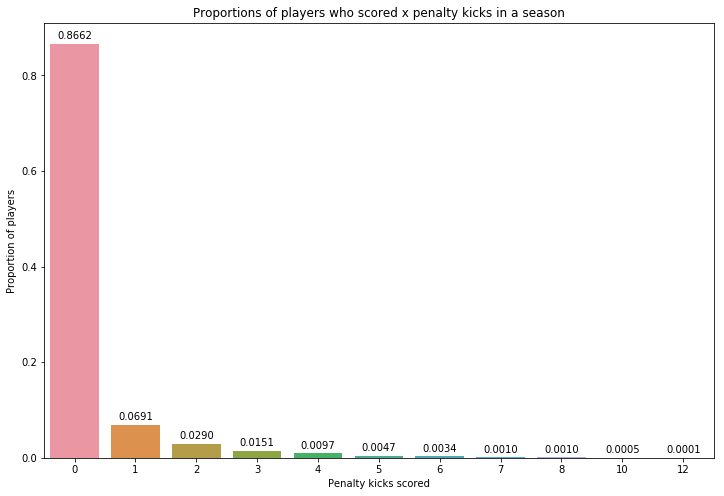

In [18]:
plt.figure(figsize=(12,8))
g = sns.barplot(x=goal_data_agg['p'].value_counts(normalize=True).index, 
                y=(goal_data_agg['p'].value_counts(normalize=True)))

# display the values on the barplot
for index, val in zip(range(0,12), goal_data_agg['p'].value_counts(normalize=True).values):
    g.text(x=index, y=val+0.01, s=format(val, '.4f'), color='black', ha="center")

plt.title("Proportions of players who scored x penalty kicks in a season")
plt.xlabel("Penalty kicks scored")
plt.ylabel("Proportion of players")
plt.show()

# this can do the similar thing as the barplot
# sns.countplot(x='p', data=goal_data_agg)

In [19]:
proportions = goal_data_agg['p'].value_counts(normalize=True)

sum = 0
for i in range(0,5):
    sum += proportions[i]
print("Proportion of players who scored 5+ penalty kicks in a season:")
print(round(1-sum, 4))

Proportion of players who scored 5+ penalty kicks in a season:
0.0107


In [20]:
print("Proportion of penalty kicks to all goals:")
print(round(goal_data_agg['p'].sum() / goal_data_agg['total'].sum(), 4))

Proportion of penalty kicks to all goals:
0.0787


Players who scored 5 or more penalty kicks in a season are a rare group -- about 1% of the players who scored any kind of goal (including own goals). But penalty kicks are rare in general -- about 7.9% of the goals -- and the designated players take most of the penalty kicks.

### Things I learned from answering question 1

- Penalty kick goals are rare: 7.9% of all goals.
- Some teams don't even score one for the entire season, while some score 13. The average is 3.8 penalty kicks per team, per season.
- Defenders and non-offensive midfielders score most of their goals via penalty kicks: Fabinho, Siqueira, Verhaegh, Murphy.
- Filip Daems (1 normal goal, 12 pk) and Paul Verhaegh (2 normal goals, 14 pk) were the best ones in this category.
- The target strikers who might not be the best penalty kick takers, such as Mario Gomez (100 normal goals, 6 pk), Stefan Kiessling (102 normal goals, 7 pk), and Fernando Llorente (86 normal goals, 6 pk) were at the bottom of the list.

## *Question 2: When are the goals scored?*
It would have been nice if I kept the columns for time, but I did not have this question before starting to answer the first question. I can go back and just keep the columns for time, but just to practice, I will start with `goals` dataframe and repeat some of the processes. Let's see what the dataframe looks like first.

In [21]:
goals.head()

,comment,coordinates,del,elapsed,elapsed_plus,event_incident_typefk,goal_x,goal_type,goals,id_x,...,BSD,BSA,id_y,team_api_id,team_fifa_api_id,team_long_name,team_short_name,id,country_id_y,league
0,n,NaN,NaN,22,NaN,406,NaN,n,NaN,378998,...,4.5,11.0,3458,10261,13.0,Newcastle United,NEW,1729,1729,England Premier League
1,n,NaN,NaN,42,NaN,406,NaN,n,NaN,462869,...,3.5,4.0,3458,10261,13.0,Newcastle United,NEW,1729,1729,England Premier League
2,p,NaN,NaN,10,NaN,20,NaN,p,NaN,462695,...,3.5,4.0,3458,10261,13.0,Newcastle United,NEW,1729,1729,England Premier League
3,n,NaN,NaN,60,NaN,407,NaN,n,NaN,473071,...,3.2,2.4,3458,10261,13.0,Newcastle United,NEW,1729,1729,England Premier League
4,n,NaN,NaN,83,NaN,393,NaN,n,NaN,473124,...,3.2,2.4,3458,10261,13.0,Newcastle United,NEW,1729,1729,England Premier League


In [22]:
# drop unwanted columns
all_columns = goals.columns.tolist()
columns_to_keep = ['player_name', 'team_long_name', 'season', 'league', 'date', 'goal_type', 
                   'elapsed', 'elapsed_plus']
columns_to_drop = [c for c in all_columns if c not in columns_to_keep]
goal_data_with_time = goals.drop(columns_to_drop, axis=1, inplace=False)
goal_data_with_time = goal_data_with_time.sort_values(by=['player_name', 'season', 'date'])
goal_data_with_time['date'] = goal_data_with_time['date'].str.slice(0,10)

# create columns for goal types
goal_categories = pd.get_dummies(goal_data_with_time['goal_type'])
goal_data_with_time = pd.concat([goal_data_with_time, goal_categories], axis=1)

# drop unuseful goal categories
# restore the integer data types
goal_data_with_time.drop(['dg', 'npm', 'o', 'rp', 'psm'], axis=1, inplace=True)
goal_data_with_time['n'] = goal_data_with_time['n'].apply(np.int64)
goal_data_with_time['p'] = goal_data_with_time['p'].apply(np.int64)

# NEW: create a column for time
goal_data_with_time['elapsed_plus'].fillna(0, inplace=True)
goal_data_with_time['elapsed_plus'] = goal_data_with_time['elapsed_plus'].apply(np.int64)
goal_data_with_time['time'] = goal_data_with_time['elapsed'] + goal_data_with_time['elapsed_plus']

# exclude the leagues and seasons with inaccurate goal data
leagues_to_include = ['England Premier League', 'Spain LIGA BBVA', 'Germany 1. Bundesliga', 
                      'Italy Serie A']
french_seasons = ['2012/2013', '2013/2014', '2014/2015', '2015/2016']
dutch_seasons = ['2014/2015', '2015/2016']

goal_data_with_time = goal_data_with_time.loc[
              ((goal_data_with_time['league'].isin(leagues_to_include)) |
              ((goal_data_with_time['league'] == 'France Ligue 1') & 
               (goal_data_with_time['season'].isin(french_seasons))) |
              ((goal_data_with_time['league'] == 'Netherlands Eredivisie') & 
               (goal_data_with_time['season'].isin(dutch_seasons))))
            ]

In [23]:
goal_data_with_time.head()

,elapsed,elapsed_plus,goal_type,player_name,season,date,team_long_name,league,n,p,time
7754,56,0,n,Aaron Cresswell,2014/2015,2014-11-29,West Ham United,England Premier League,1,0,56
7748,7,0,n,Aaron Cresswell,2014/2015,2015-04-11,West Ham United,England Premier League,1,0,7
7755,45,3,n,Aaron Cresswell,2015/2016,2015-12-26,West Ham United,England Premier League,1,0,48
7627,86,0,n,Aaron Cresswell,2015/2016,2016-04-17,West Ham United,England Premier League,1,0,86
5100,11,0,n,Aaron Hughes,2010/2011,2010-12-26,Fulham,England Premier League,1,0,11


In [24]:
goal_data_with_time.dtypes

elapsed            int64
elapsed_plus       int64
goal_type         object
player_name       object
season            object
date              object
team_long_name    object
league            object
n                  int64
p                  int64
time               int64
dtype: object

### Bar graph for goals scored on each minute

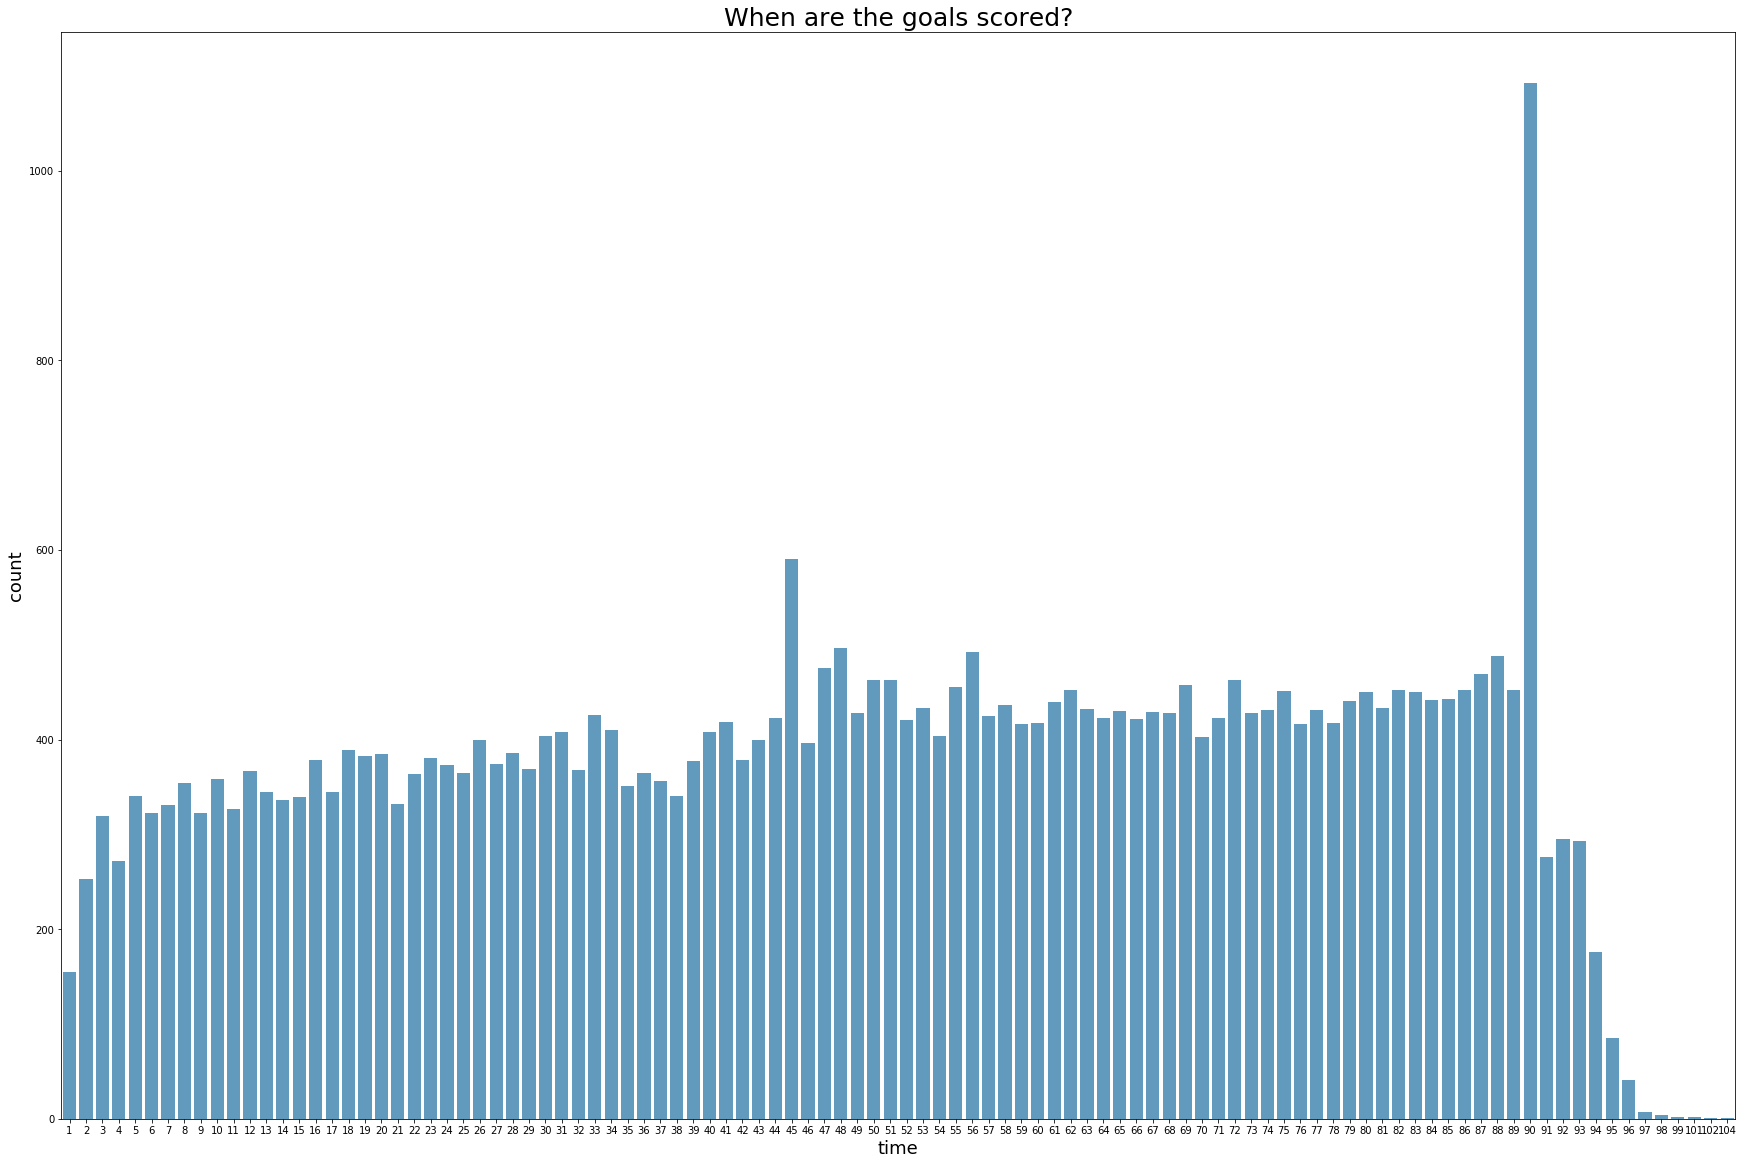

In [25]:
plt.figure(figsize=(30,20))
plt.title("When are the goals scored?", fontsize=25)
plt.xlabel("Minute", fontsize=18)
plt.ylabel("Number of goals scored", fontsize=18)
sns.countplot(x='time', data=goal_data_with_time, color=sns.color_palette("Blues")[3])

In [26]:
goal_data_with_time.loc[goal_data_with_time['time'] == 90].head(10)

,elapsed,elapsed_plus,goal_type,player_name,season,date,team_long_name,league,n,p,time
10393,90,0,n,Aaron Hunt,2009/2010,2009-10-31,SV Werder Bremen,Germany 1. Bundesliga,1,0,90
10414,90,0,n,Aaron Hunt,2013/2014,2014-05-03,SV Werder Bremen,Germany 1. Bundesliga,1,0,90
32216,90,0,n,Abdelkader Ghezzal,2008/2009,2008-09-14,Siena,Italy Serie A,1,0,90
32174,90,0,n,Abdelkader Ghezzal,2009/2010,2009-12-13,Siena,Italy Serie A,1,0,90
21481,90,0,n,Abdoul Karim Yoda,2014/2015,2014-10-20,Getafe CF,Spain LIGA BBVA,1,0,90
27221,90,0,p,Abel Hernandez,2011/2012,2011-10-02,Palermo,Italy Serie A,0,1,90
20202,90,0,n,Abraham Minero,2011/2012,2012-03-04,Real Zaragoza,Spain LIGA BBVA,1,0,90
6454,90,0,n,Adam Johnson,2014/2015,2014-12-21,Sunderland,England Premier League,1,0,90
14308,90,0,n,Adam Szalai,2013/2014,2014-03-22,FC Schalke 04,Germany 1. Bundesliga,1,0,90
31498,90,0,p,Adem Ljajic,2013/2014,2013-09-22,Roma,Italy Serie A,0,1,90


This can't be right. There must be some seasons of data that recorded goals happened after the 90th minute as 90th-minute goals, and from a few quick checks on these goals, I can confirm that. It's a little sad, but I need to drop the goals scored from 45th minute and on in the first half and the goals scored from 90th minute and on in the second half.

### Bar graph for goals scored on each minute, except for 45+ and 90+ minutes

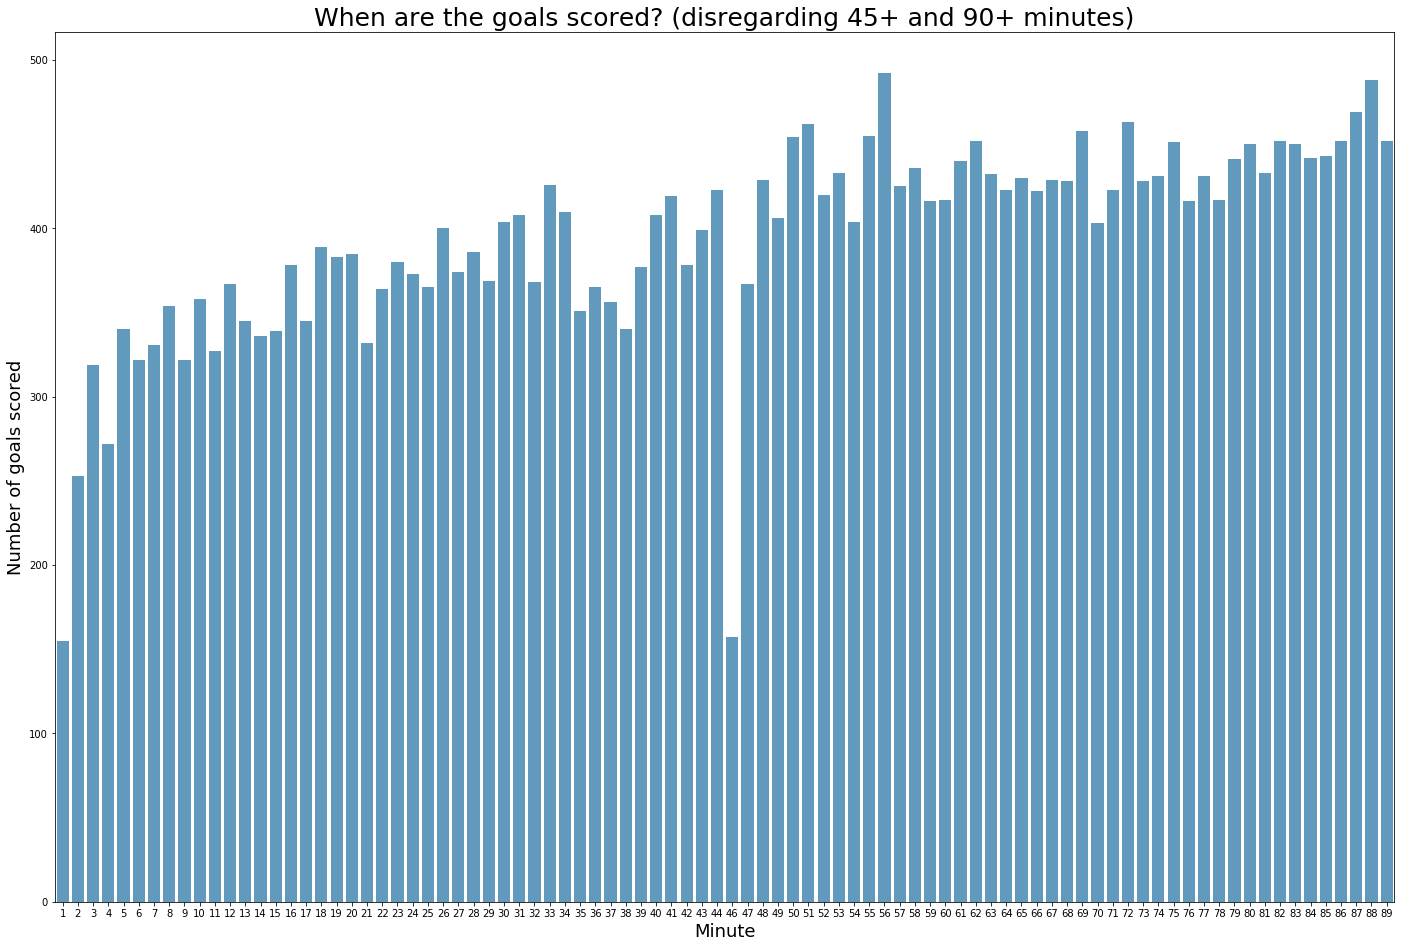

In [27]:
goal_data_reg = goal_data_with_time.loc[(goal_data_with_time['elapsed'] < 45) |
                                        ((goal_data_with_time['elapsed'] > 45) & 
                                         (goal_data_with_time['elapsed'] < 90))
                                       ]
plt.figure(figsize=(24,16))
goal_time_plot = sns.countplot(x='time', data=goal_data_reg, color=sns.color_palette("Blues")[3])
plt.title("When are the goals scored? (disregarding 45+ and 90+ minutes)", fontsize=25)
plt.xlabel("Minute", fontsize=18)
plt.ylabel("Number of goals scored", fontsize=18)

goal_time_plot.get_figure().savefig("goaltime.png")

The first minute of either half sees much fewer goals – this makes sense because the players would usually try to ease themselves into the games.<br>
This histogram can basically be read as a scatter plot, and there seems to be a slightly linear, upward trend as the times goes on. Let's check the Pearson correlation coefficient.

In [28]:
minutes = pd.Series(goal_data_reg['time'].value_counts().index)
goal_freqs = pd.Series(goal_data_reg['time'].value_counts().values)

print("Correlation between the goal totals and the time they were scored at:")
print(round(minutes.corr(goal_freqs), 4))

Correlation between the goal totals and the time they were scored at:
0.7373


There is a decent correlation between time and goals scored. Let's get rid of the first minutes of either half and see.

In [29]:
goal_data_reg_not_first_minutes = goal_data_reg.loc[(goal_data_with_time['time'] != 1) &
                                                    (goal_data_with_time['time'] != 46)]

minutes = pd.Series(goal_data_reg_not_first_minutes['time'].value_counts().index)
goal_freqs = pd.Series(goal_data_reg_not_first_minutes['time'].value_counts().values)

print("Correlation between the goal totals and the time they were scored at: (not counting 1st and 46th")
print("minutes):")
print(round(minutes.corr(goal_freqs), 4))

Correlation between the goal totals and the time they were scored at: (not counting 1st and 46th
minutes):
0.8494


There is a fairly strong correlation now. Pretty cool. I would guess that as players get tired and get deperate to change the outcome of the match, defensive organization and discipline get weaker and lead to more goals. Is this true for every league? Let's take a look.

### Does every league have a different pattern?

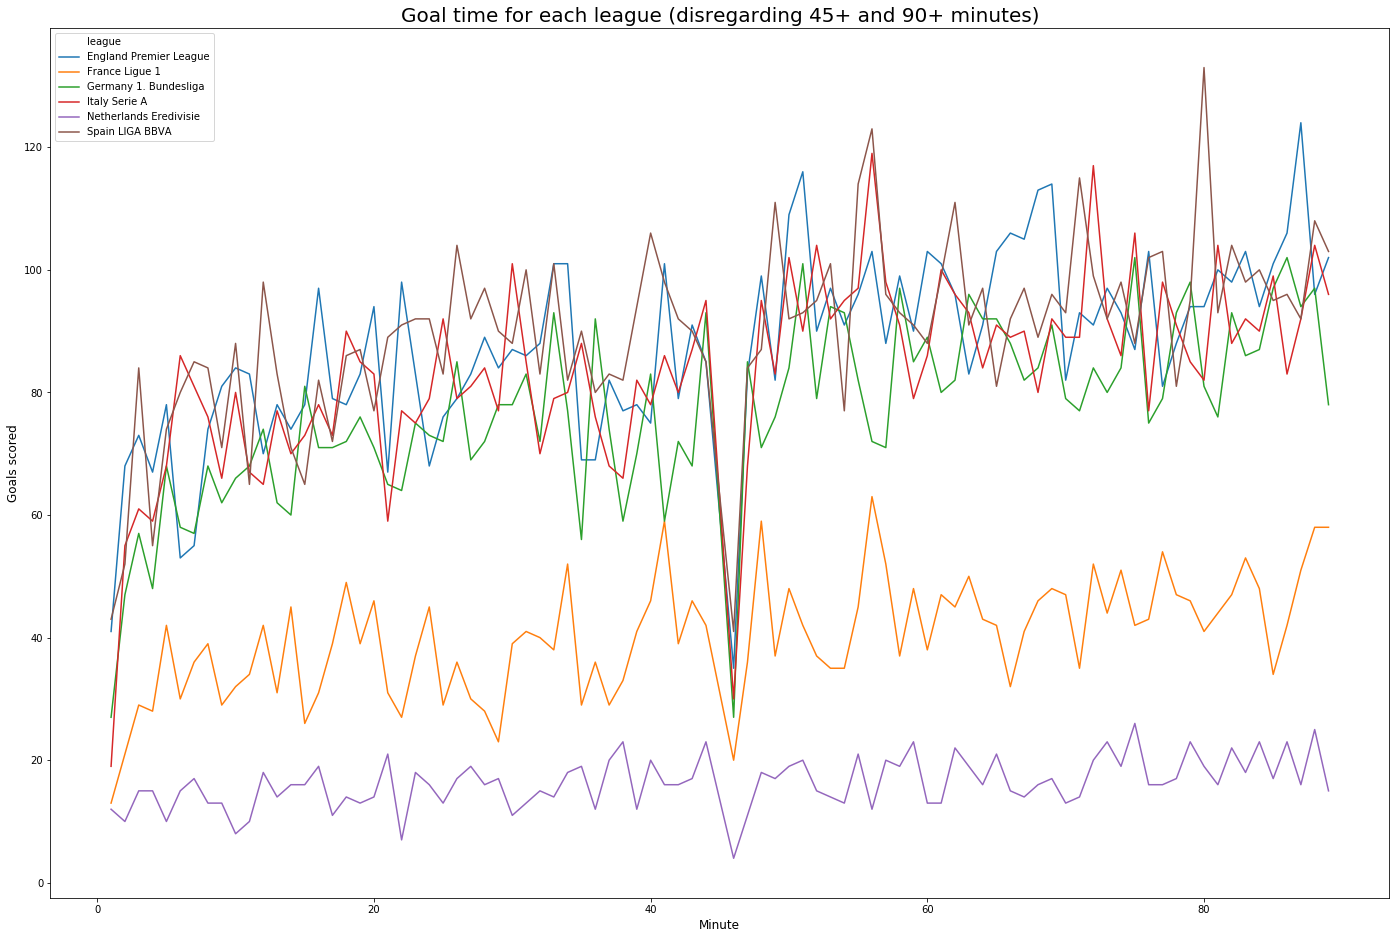

In [30]:
goal_data_reg_leagues = goal_data_reg.groupby(['league', 'time']).size().reset_index()
goal_data_reg_leagues.rename({0: 'goals_per_minute'}, axis='columns', inplace=True)

plt.figure(figsize=(24,16))
sns.lineplot(x='time', y='goals_per_minute', hue='league', data=goal_data_reg_leagues)
plt.title("Goal time for each league (disregarding 45+ and 90+ minutes)", fontsize=20)
plt.xlabel("Minute", fontsize=12)
plt.ylabel("Goals scored", fontsize=12)
plt.show()

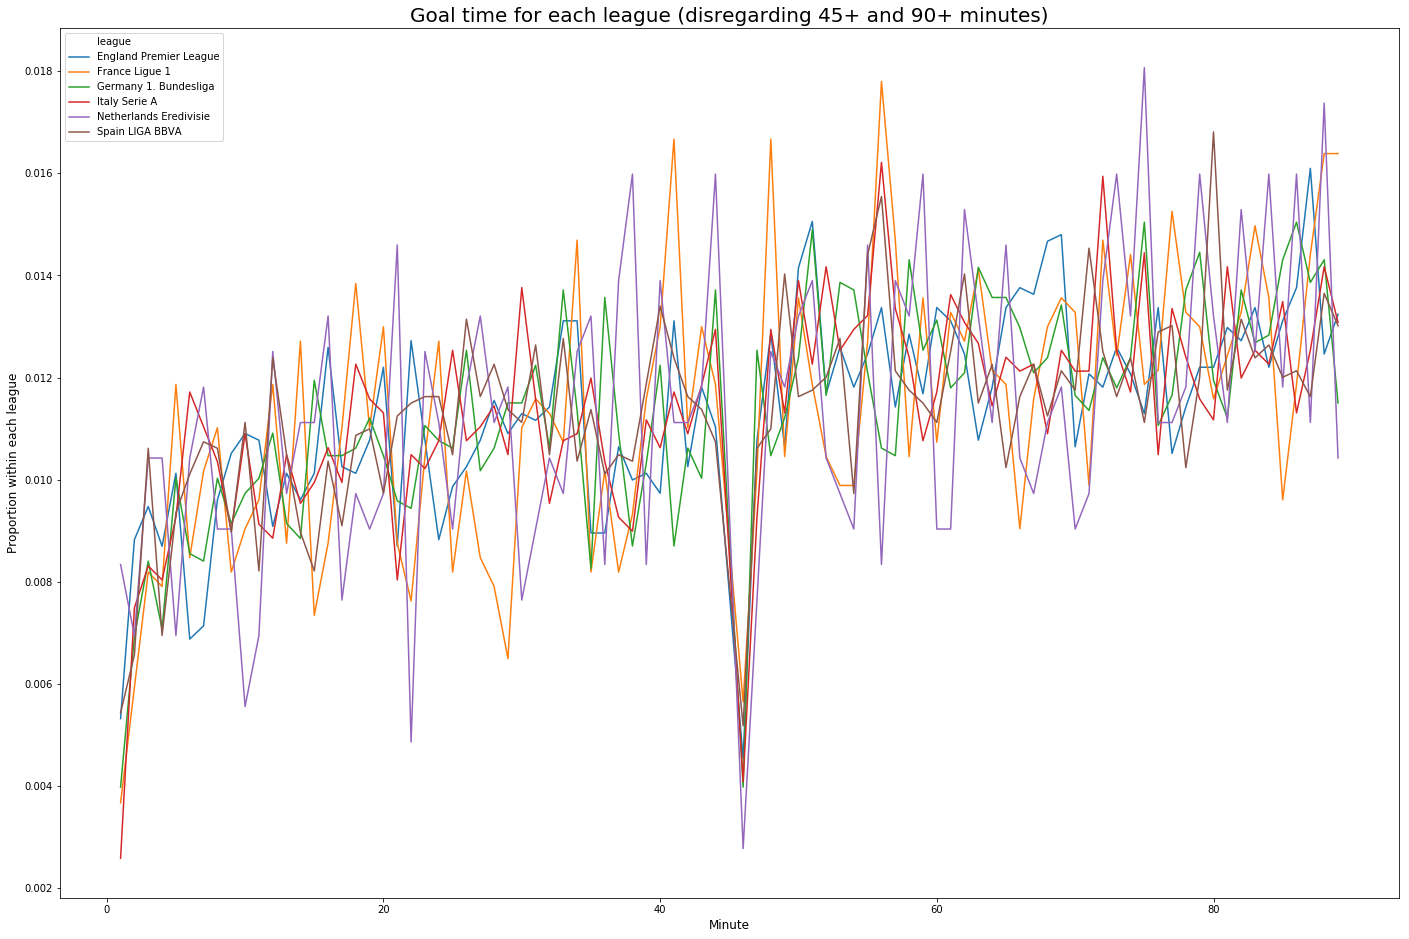

In [31]:
goal_data_reg_leagues_proportion = (goal_data_reg.groupby('league')['time']
                                                 .value_counts(normalize=True)
                                                 .reset_index(name='proportion_per_minute'))

plt.figure(figsize=(24,16))
sns.lineplot(x='time', y='proportion_per_minute', hue='league', 
             data=goal_data_reg_leagues_proportion)
plt.title("Goal time for each league (disregarding 45+ and 90+ minutes)", fontsize=20)
plt.xlabel("Minute", fontsize=12)
plt.ylabel("Proportion within each league", fontsize=12)
plt.show()

Unfortunately, it's hard to find insights from these lineplots.

### Is the timing of goal scoring different for normal goal and penalty kicks?

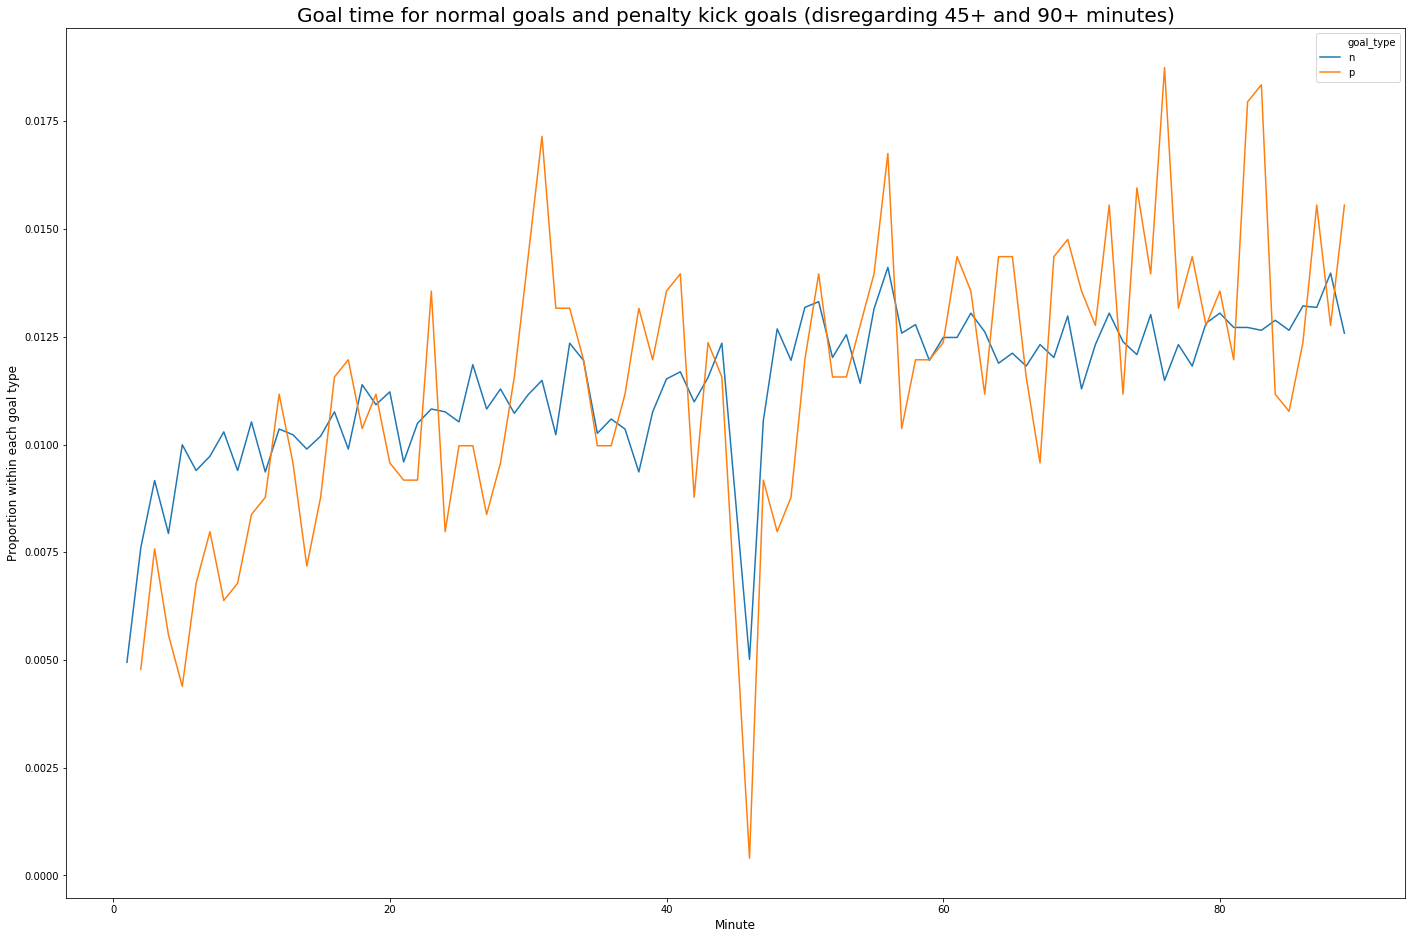

In [32]:
goal_data_reg_goal_type = (goal_data_reg.groupby('goal_type')['time']
                                        .value_counts(normalize=True)
                                        .reset_index(name='proportion_per_minute'))
goal_data_reg_goal_type = goal_data_reg_goal_type.loc[
                                        (goal_data_reg_goal_type['goal_type'] == 'n') |
                                        (goal_data_reg_goal_type['goal_type'] == 'p')]

plt.figure(figsize=(24,16))
sns.lineplot(x='time', y='proportion_per_minute', hue='goal_type', data=goal_data_reg_goal_type, 
             markers=True)
plt.title("Goal time for normal goals and penalty kick goals (disregarding 45+ and 90+ minutes)", 
          fontsize=20)
plt.xlabel("Minute", fontsize=12)
plt.ylabel("Proportion within each goal type", fontsize=12)
plt.show()

It looks like the graph for the penalty kicks has more spikes, but that could be due to its relatively smaller sample size for each minute category.

I had this theory that the penalty kick proportions late in the game would be lower than the normal goal proportions because the referees might be reluctant to make tough calls that could decide the results of the matches, but this graph tells me that I'm wrong -- the penalty kick proportions are higher than the normal goal proportions in the second half. Perhaps, there are not many close matches anyway for the referees to feel that pressure.

In [33]:
goal_data_minute = (goal_data_reg.groupby('time').sum().reset_index()
                                 .drop(['elapsed', 'elapsed_plus'], axis=1))

goal_data_minute['relative_proportion_n'] = goal_data_minute['n'] / goal_data_minute['n'].sum()
goal_data_minute['relative_proportion_p'] = goal_data_minute['p'] / goal_data_minute['p'].sum()

In [34]:
goal_data_minute['p>n'] = np.where(
    goal_data_minute['relative_proportion_p'] > goal_data_minute['relative_proportion_n'],
    True, False)

In [35]:
goal_data_minute['p>n'].value_counts()

False    47
True     41
Name: p>n, dtype: int64

In [36]:
goal_data_minute.loc[goal_data_minute['time'] < 45]['p>n'].value_counts()

False    27
True     17
Name: p>n, dtype: int64

In [37]:
goal_data_minute.loc[goal_data_minute['time'] > 45]['p>n'].value_counts()

True     24
False    20
Name: p>n, dtype: int64

### Things I learned from answering question 2
- More goals are scored as the matches go on: the goal totals and the time they were scored have a ~0.85 correlation.
- Much less goals (about half less than any other minutes) are scored on the 1st and 46th minutes of the matches.
- Relative proportion of penalty kick goals are higher than that of normal goals in the second half. (24:20)

And that's it! Thank you.